Before starting the program, upload the animal_latin_colloquial.csv file from data folder in the github repo to home folder in google colab

# Imports

In [1]:
import os
import requests
import pandas as pd
from PIL import Image
from io import BytesIO
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from tqdm import tqdm  # Progress bar

# For loading in dataset images and annotations
import json
import os

from etils import epath
import numpy as np
import tensorflow_datasets.public_api as tfds

# Displaying sample images
import itertools

import tarfile
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import matplotlib.pyplot as plt
import numpy as np
import pathlib

# python imaging library
# adds image processing capabilities to the interpreter
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers.experimental import preprocessing

# Animal pipeline class

In [2]:
# Animal Pipeline class from src/preprocessing folder
class AnimalPipeline:
    def __init__(self, dataset_path):
        self.dataset = pd.read_csv(dataset_path)
        self.dataset['Colloquial Name'] = self.dataset['Colloquial Name'].str.strip().str.lower()
        self.dataset['Latin Name'] = self.dataset['Latin Name'].str.strip().str.lower()

    def sanitize_name(self, name):
        """ Sanitize the input name to match the dataset format. """
        return name.strip().lower()  # Convert to lowercase and remove leading/trailing spaces

    def animal_exists(self, colloquial_name):
        """ Check if an animal exists in the dataset by its colloquial name. """
        sanitized_name = self.sanitize_name(colloquial_name)
        exists = not self.dataset[self.dataset['Colloquial Name'] == sanitized_name].empty
        if exists:
            print(f"'{colloquial_name}' exists in the dataset.")
        else:
            print(f"'{colloquial_name}' does not exist in the dataset.")
        return exists

    def get_latin_name(self, colloquial_name):
        """ Get the Latin name for a given colloquial name if it exists. """
        sanitized_name = self.sanitize_name(colloquial_name)
        result = self.dataset[self.dataset['Colloquial Name'] == sanitized_name]
        if not result.empty:
            latin_name = result['Latin Name'].values[0]
            return latin_name
        else:
            print(f"No Latin name found for '{colloquial_name}' in the dataset.")
            return None

    def get_latin_names(self, colloquial_names):
        """ Get a list of Latin names for the given list of colloquial names. """
        latin_names = []
        for name in colloquial_names:
            latin_name = self.get_latin_name(name)
            if latin_name:
                latin_names.append(latin_name)
        return latin_names

    def check_latin_name(self, latin_name):
        """ Check if a Latin name exists in the dataset. """
        sanitized_name = self.sanitize_name(latin_name)
        exists = not self.dataset[self.dataset['Latin Name'] == sanitized_name].empty
        return exists

# Gathering species and number of images per species

In [9]:
species_names = []
numAnimals = int(input("Enter the number of animals you want to train: \n"))
for i in range(numAnimals):
    species_names.append(input("Enter the name of the animal: \n"))

max_images_per_species = int(input("Enter the maximum number of images you want to download for each animal: \n"))

file_path = "/home/animal_latin_colloquial.csv"

pipeline = AnimalPipeline(file_path)

for name in species_names.copy():
    if pipeline.animal_exists(name) == False:
        if pipeline.check_latin_name(name) == False:
            print(f"{name} does not exist in the dataset. Please enter a valid animal name.")
            species_names.remove(name)
            continue
    latin_name = pipeline.get_latin_name(name)
    species_names.remove(name)
    species_names.append(latin_name)

IMG_HEIGHT = 180; IMG_WIDTH = 180   # size of image has to 180x180 since ResNet50 is used

Enter the number of animals you want to train: 
1
Enter the name of the animal: 
lion
Enter the maximum number of images you want to download for each animal: 
1
'lion' exists in the dataset.


# Loading inaturalist images for training split via iNaturalist API

In [10]:
# Function to download and resize image
def download_and_resize_image(url, save_dir, obs_id, max_size=(IMG_HEIGHT, IMG_WIDTH)):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        img = img.resize(max_size, resample = Image.Resampling.BICUBIC)

        # Ensure the save directory exists
        os.makedirs(save_dir, exist_ok=True)

        # Save the image with a unique name based on the observation ID
        img_name = f"{obs_id}.jpg"
        img_path = os.path.join(save_dir, img_name)
        img.save(img_path)
        return img_path
    except Exception as e:
        return None

In [11]:
session = requests.Session()
retry_strategy = Retry(
    total=3,
    status_forcelist=[429, 500, 502, 503, 504],
    backoff_factor=1
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session.mount('https://', adapter)

for species_name in species_names:
    try:
        # Directory to save images for the current species, change as needed
        save_dir = f'/home/DataSet/{species_name.replace(" ", "_")}_images'

        # Fetch taxon ID for the current species name
        search_response = session.get(f'https://api.inaturalist.org/v1/taxa?q={species_name}&rank=species', timeout=10).json()
        if not search_response['results']:
            print(f"No taxon found for species: {species_name}")
            continue

        # Assume the first result is the desired species
        taxon_id = search_response['results'][0]['id']

        observation_ids = []
        image_urls = []
        common_names = []
        scientific_names = []

        valid_image_count = 0

        # Fetch observations for the current species until the desired number of images is reached
        page = 1
        while valid_image_count < max_images_per_species:
            observations_response = session.get(
                f'https://api.inaturalist.org/v1/observations?taxon_id={taxon_id}&per_page=200&page={page}', timeout=10
            ).json()
            observations = observations_response['results']

            if not observations:
                break

            for observation in tqdm(observations, desc=f'Processing observations for {species_name}'):
                if valid_image_count >= max_images_per_species:
                    break

                # Extract and store observation details
                obs_id = observation['id']
                taxon = observation.get('taxon')
                if taxon:
                    common_name = taxon.get('preferred_common_name', 'No common name available')
                    scientific_name = taxon.get('name', 'No scientific name available')
                else:
                    common_name = 'No common name available'
                    scientific_name = 'No scientific name available'

                # Extract and store image data
                if 'observation_photos' in observation and observation['observation_photos']:
                    photo = observation['observation_photos'][0]['photo']
                    image_url = photo['url']
                    image_path = download_and_resize_image(image_url, save_dir=save_dir, obs_id=obs_id, max_size = (IMG_HEIGHT, IMG_WIDTH))
                    if image_path:
                        observation_ids.append(obs_id)
                        common_names.append(common_name)
                        scientific_names.append(scientific_name)
                        image_urls.append(image_url)
                        valid_image_count += 1

            page += 1

        # Create a DataFrame with observation details for the current species
        data = {
            'Observation ID': observation_ids,
            'Common Name': common_names,
            'Scientific Name': scientific_names,
            'Image URL': image_urls,
            'Image Path': [os.path.join(save_dir, f"{obs_id}.jpg") for obs_id in observation_ids]
        }
        df = pd.DataFrame(data)

        # Cap the dataset size to match the number of images available
        if valid_image_count < max_images_per_species:
            df = df.head(valid_image_count)

        # Save to a CSV file for the current species, change as needed
        csv_path = f'/home/{species_name.replace(" ", "_")}_dataset.csv'
        df.to_csv(csv_path, index=False)

        print(f"Data saved to {csv_path} for species: {species_name}")

    except requests.exceptions.HTTPError as e:
        print(f"HTTP error occurred: {e}")

Processing observations for panthera leo:   0%|          | 1/200 [00:00<02:05,  1.59it/s]

Data saved to /home/panthera_leo_dataset.csv for species: panthera leo


In [12]:
# Count number of images downloaded
path = '/home/DataSet'
folders = os.listdir(path)
totalImages = 0
for folder in folders:
  images = os.listdir(f"{path}/{folder}")
  totalImages += len(images)

print(totalImages)

1


# Loading inaturalist images for validation split via inat competition 2021

## Setup

In [13]:
dm = tfds.download.DownloadManager(download_dir='/home')

URL = 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021'    # endpoint to load images from

# maps split type to split file name
SPLIT_FILENAMES = {
    'train': 'train',
    'mini': 'train_mini',
    'val': 'val',
    'test': 'public_test',
}

# Only load validation set
SPLIT = 'val'
SPLIT_FILE = SPLIT_FILENAMES[SPLIT]

# maps dataset to split tar & json files
splitDownloads = {}

## Download

In [14]:
# download image tar file
splitDownloads[f'{SPLIT}_img'] =  tfds.download.Resource(
          url=f'{URL}/{SPLIT_FILE}.tar.gz',
          extract_method=tfds.download.ExtractMethod.NO_EXTRACT,
      )
# download json annotation file
splitDownloads[f'{SPLIT}_json'] = f'{URL}/{SPLIT_FILE}.json.tar.gz'

print(splitDownloads)

outputPaths = dm.download_and_extract(splitDownloads)     # downloading the tar file containing validation images

{'val_img': <tensorflow_datasets.core.download.resource.Resource object at 0x7dfa75c0fb20>, 'val_json': 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021/val.json.tar.gz'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

## Retrieving annotations from JSON file to load images from validation dataset


In [15]:
# paths to loaded dataset

imagesArchive = outputPaths[f'{SPLIT}_img']
jsonFile = os.path.join(outputPaths[f'{SPLIT}_json'],f'{SPLIT_FILE}.json')

In [16]:
with epath.Path(jsonFile).open('r') as f:
      inatJson = json.load(f)

In [17]:
def format(label: str):
      # replace ' ' with '_' in a string
      return label.lower().replace(' ', '_')

# retrieves annotations (categories, id and image directory) for an image
def getAnnotation(idx, image_id):

      if 'annotations' in inatJson:

        # get the annotations object that matches our ID
        annotation = inatJson['annotations'][idx]
        assert annotation['image_id'] == image_id

        # retrieve 'categories' object corresponding to the id in the annotation object
        cat = inatJson['categories'][annotation['category_id']]

        # extract important metadata
        category = format(cat['name'])
        superCategory = format(cat['supercategory'])
        imageDirectory = cat['image_dir_name']

      else:
        # no metadata found
        category, superCategory, imageDirectory = -1, -1, -1

      return category, superCategory, imageDirectory

## Curating collection of annotated images

###Filtering

The code below allows us ensure that we only extract images related to vertebrates and our 5 selected species.

In [18]:
# List containing the vertebrates recognised by iNaturalist Dataset
vertebrates = ["jawless_fishes", "hagfishes", "lampreys", "ray-finned_fishes", "amphibians", "birds", "elasmobranchs", "chimaeras", "mammals", "reptiles", "lobe-finned_fishes"]

In [19]:
# List containing the animals that user want to see/train on
animalsToRetrieve = [format(name).lower() for name in species_names]      # formated so that images can be recognised
print(animalsToRetrieve)

['panthera_leo']


###Map images to their annotations

In [20]:
annotatedFiles = {}   # stores specified annotation and metadata of species

for idx, image in enumerate(inatJson['images']):

  category, superCategory, imageDirectory = getAnnotation(idx, image['id'])
  if (superCategory in vertebrates) and (category in animalsToRetrieve):      # Checking if the species is a vertebrate and checking latin name of the animal (using category)
    field = os.path.basename(image['file_name']).split('.')[0]

    annotatedFiles[field] = {
        'id': image['id'],
        'file_id': field,
        'label': category,      # latin name
        'superCategory': superCategory,
        'imagedirectory' : imageDirectory,
    }

In [21]:
print(annotatedFiles)
print(len(annotatedFiles))

{'300262a5-cf42-4296-ad50-d9d305e19a80': {'id': 2687910, 'file_id': '300262a5-cf42-4296-ad50-d9d305e19a80', 'label': 'panthera_leo', 'superCategory': 'mammals', 'imagedirectory': '04682_Animalia_Chordata_Mammalia_Carnivora_Felidae_Panthera_leo'}, 'ca25da17-453a-472f-b0b1-8c46a36b2948': {'id': 2710221, 'file_id': 'ca25da17-453a-472f-b0b1-8c46a36b2948', 'label': 'panthera_leo', 'superCategory': 'mammals', 'imagedirectory': '04682_Animalia_Chordata_Mammalia_Carnivora_Felidae_Panthera_leo'}, 'ae9adbce-1809-4263-8737-020aee79e657': {'id': 2713425, 'file_id': 'ae9adbce-1809-4263-8737-020aee79e657', 'label': 'panthera_leo', 'superCategory': 'mammals', 'imagedirectory': '04682_Animalia_Chordata_Mammalia_Carnivora_Felidae_Panthera_leo'}, '83b87a73-0f1c-4bf0-9220-86d5789626d9': {'id': 2718258, 'file_id': '83b87a73-0f1c-4bf0-9220-86d5789626d9', 'label': 'panthera_leo', 'superCategory': 'mammals', 'imagedirectory': '04682_Animalia_Chordata_Mammalia_Carnivora_Felidae_Panthera_leo'}, 'bcbf1577-1003-

## Extracting the images

In [22]:
# image file paths in tar.gz file
imgToExtract = []

try:
  t = tarfile.open(imagesArchive, 'r')

except IOError as e:
  print(e)

else:

  for id,value in annotatedFiles.items():

    # create image file path
    imgFilePath = f"val/{value['imagedirectory']}/{id}.jpg"         # specfying the file path to store the extracted images
    imgToExtract.append(imgFilePath)

  t.extractall('/home', members=imgToExtract)


## Resizing and renaming

In [23]:
from PIL import Image
import os,sys

# rename all folders to match class names of the training dataset
path = '/home/val'
dirs = os.listdir(path)

for folder in dirs:
  # rename species folder
  os.rename(f"{path}/{folder}", f"{path}/{'_'.join(folder.split('_')[6::])}_images")

  # get path of each image in class folder
  new_path = f"{path}/{'_'.join(folder.split('_')[6::])}_images"
  image_dir = os.listdir(new_path)

  for item in image_dir:
    item_path = f"{new_path}/{item}"

    if os.path.isfile(item_path):
      im = Image.open(item_path)
      f, e = os.path.splitext(item_path)
      imResize = im.resize((IMG_HEIGHT, IMG_WIDTH))     # resizing image so that it can be read by the model
      imResize.save(item_path,'JPEG', quality=90)

# Building the Model

## Preprocessing / Creating dataset

In [24]:
BATCH_SIZE = 32
data_dir = pathlib.Path('/home/DataSet').with_suffix('')  # Directory storing the training data

# Quick check on the dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Found {image_count} images.")

# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=None,
    subset=None,
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Identifying class names
class_names = train_ds.class_names
print(class_names)

# Print a batch shape
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

# Creating the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    '/home/val',
    validation_split=None,
    subset=None,
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Configuring dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Number of classes
NUM_CLASSES = len(class_names)

Found 1 images.
Found 1 files belonging to 1 classes.
['panthera_leo_images']
(1, 180, 180, 3)
(1,)
Found 10 files belonging to 1 classes.


## Creating, compiling and training the model

In [25]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the pretrained weights
resnet_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = resnet_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(NUM_CLASSES)(x)
model = keras.Model(inputs, outputs)


# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# using 10 epochs of size 32 and with model.fit method
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/10
1/1 [==============================] - 8s 8s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 1s 1s/step - lo

## Visualising model results

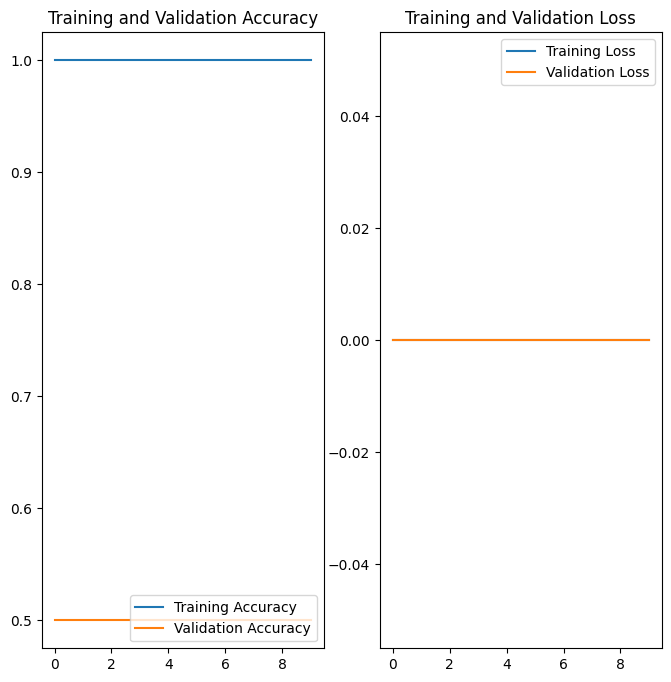

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()